In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

from querymsc import WorkflowTools
%load_ext autoreload
%autoreload 2

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
start_time = datetime.datetime(1990, 1, 1)
end_time = datetime.datetime(2005, 1, 1)

msc = WorkflowTools(start_time, end_time)

15.0


In [5]:
annual_tot_precip = msc.query_annual_precip(session)
annual_tot_rain = msc.query_annual_rain(session)
query_temp = msc.query_design_temp_percentile(session)

In [6]:
query = msc.query_design_temp_percentile(session)

In [7]:
annual_tot_precip = msc.query_annual_precip(session)
#pd.read_sql(annual_tot_precip.statement, engine)

,annual_precip,time_min,time_max,lat,lon,station_id,obs_count,completeness
0,84.313333,1999-01-01,2004-12-31,-104.7110,-104.7110,10674,2068,0.377441
1,272.686667,1990-01-01,1994-09-30,41.7833,-82.6833,6063,1734,0.316481
2,0.000000,2001-08-03,2003-08-18,41.8333,-82.4667,6103,721,0.131593
3,296.466667,1999-01-01,2004-11-30,41.9486,-82.5189,6143,1816,0.331447
4,329.826667,1990-01-01,1997-09-30,41.9500,-82.5167,6140,2000,0.365030
5,168.793333,1990-01-01,1993-06-30,42.0333,-82.9000,6036,906,0.165359
6,253.466667,2000-01-01,2004-12-31,42.0333,-82.9000,6037,1725,0.314838
7,440.646667,1992-01-01,2000-08-31,42.0333,-82.9000,6138,3132,0.571637
8,866.613333,1990-01-01,2004-12-31,42.0431,-82.6739,6040,5439,0.992699
9,905.426667,1990-01-01,2004-12-31,42.1034,-83.0945,5992,5479,1.000000


In [8]:
annual_tot_rain = msc.query_annual_rain(session)
#pd.read_sql(annual_tot_rain.statement, engine)

,annual_rain,time_min,time_max,lat,lon,station_id,completeness
0,58.353333,1999-05-01,2004-12-31,-104.7110,-104.7110,10674,0.333455
1,251.893333,1990-01-01,1994-09-30,41.7833,-82.6833,6063,0.316481
2,0.000000,1999-01-02,1999-03-30,41.9486,-82.5189,6143,0.009673
3,283.540000,1990-01-01,1997-09-30,41.9500,-82.5167,6140,0.341121
4,139.300000,1990-01-01,1993-06-30,42.0333,-82.9000,6036,0.154955
5,0.000000,2004-11-01,2004-11-11,42.0333,-82.9000,6037,0.000730
6,198.393333,1992-06-01,1997-04-30,42.0333,-82.9000,6138,0.299690
7,777.153333,1990-01-01,2004-12-31,42.0431,-82.6739,6040,0.965687
8,809.380000,1990-01-01,2004-12-31,42.1034,-83.0945,5992,0.981931
9,180.126667,1990-01-01,1994-08-31,42.2000,-82.2000,6071,0.280343


In [9]:
query_temp = msc.query_design_temp_percentile(session)
#pd.read_sql(query_temp.statement, engine)

,air_temperature,time_min,time_max,lat,lon,station_id,completeness
0,-37.874,2000-01-01,2004-01-31,-104.7110,-104.7110,10674,0.333333
1,-24.040,1990-01-01,1994-01-31,41.7833,-82.6833,6063,0.316129
2,-16.216,1996-01-01,2002-01-31,41.8333,-82.4667,6103,0.458065
3,-21.558,1999-01-01,2004-01-31,41.9486,-82.5189,6143,0.264516
4,-23.020,1990-01-01,1994-01-31,41.9500,-82.5167,6140,0.322581
5,-16.565,1990-01-01,1992-01-31,42.0333,-82.9000,6036,0.189247
6,-23.560,2001-01-01,2004-01-31,42.0333,-82.9000,6037,0.264516
7,-21.815,1992-01-01,2000-01-31,42.0333,-82.9000,6138,0.597849
8,-23.000,1990-01-01,2003-01-31,42.0431,-82.6739,6040,0.883871
9,-21.000,1990-01-01,2003-01-31,42.1034,-83.0945,5992,0.907527


In [10]:
query_design_temp_dry = msc.query_design_temp_dry(session)
pd.read_sql(query_design_temp_dry.statement, engine).head()

,wet_bulb_temperature,time_min,time_max,lat,lon,station_id,completeness
0,16.6000,1999-07-01,2004-07-31,-104.7110,-104.7110,10674,0.400000
1,20.8500,1990-07-01,1994-07-31,41.7833,-82.6833,6063,0.333333
2,19.3450,2004-07-01,2004-07-31,41.8333,-82.4667,6103,0.058065
3,19.1625,1999-07-01,2004-07-31,41.9486,-82.5189,6143,0.313978
4,19.9500,1990-07-01,1997-07-31,41.9500,-82.5167,6140,0.324731


In [11]:
query_design_temp_wet = msc.query_design_temp_wet(session)
pd.read_sql(query_design_temp_wet.statement, engine)

,wet_bulb_temp,time_min,time_max,lat,lon,station_id,completeness,obs_count
0,7.4000,2002-07-01 00:00:00,2004-07-31 23:00:00,-104.7110,-104.7110,10674,0.197491,2204
1,9.9000,1995-07-01 00:00:00,2002-07-31 23:00:00,41.8333,-82.4667,6103,0.388710,4338
2,11.8000,2002-07-01 00:00:00,2004-07-31 23:00:00,41.9486,-82.5189,6143,0.199731,2229
3,11.3000,2001-07-01 00:00:00,2004-07-31 23:00:00,42.0333,-82.9000,6037,0.199552,2227
4,12.6300,1997-07-01 00:00:00,2002-07-31 23:00:00,42.2501,-81.9001,6141,0.198297,2213
5,12.3000,1990-07-01 00:00:00,2004-07-31 23:00:00,42.2756,-82.9556,6130,0.995341,11108
6,13.6975,1997-07-01 00:00:00,2004-07-31 23:00:00,42.3000,-82.7000,5997,0.462366,5160
7,12.4475,2004-07-01 00:00:00,2004-07-31 23:00:00,42.4500,-81.8833,6083,0.066308,740
8,10.3000,1997-07-01 00:00:00,1997-07-31 23:00:00,42.8500,-80.2667,6099,0.066487,742
9,10.1000,2000-07-01 00:00:00,2002-07-31 23:00:00,42.8667,-80.5500,6014,0.199731,2229


In [13]:
hdd = msc.query_deg_day_below_18(session)
pd.read_sql(hdd.statement, engine)

,hdd,time_min,time_max,lat,lon,station_id,completeness
0,1953.766667,1999-04-01,2004-12-31,-104.7110,-104.7110,10674,0.358095
1,850.373333,1990-01-01,1994-09-30,41.7833,-82.6833,6063,0.314108
2,1261.820000,1995-09-21,2004-12-31,41.8333,-82.4667,6103,0.457018
3,916.173333,1999-01-01,2004-12-31,41.9486,-82.5189,6143,0.293302
4,1031.020000,1990-01-01,1997-09-30,41.9500,-82.5167,6140,0.339113
5,446.146667,1990-01-01,1993-06-30,42.0333,-82.9000,6036,0.151853
6,920.220000,2000-07-26,2004-12-31,42.0333,-82.9000,6037,0.292207
7,1691.593333,1992-01-01,2000-08-31,42.0333,-82.9000,6138,0.571820
8,2624.446667,1990-01-01,2003-12-31,42.0431,-82.6739,6040,0.899252
9,2613.813333,1990-01-01,2003-12-31,42.1034,-83.0945,5992,0.920058


In [22]:
df_vars = pd.read_sql(msc.query_variables(session).statement, engine)
#df_vars[df_vars['net_var_name']=='127']
#df_vars[(df_vars['net_var_name'].astype(int) > 124) & (df_vars['net_var_name'].astype(int) < 132)]
df_vars[df_vars['standard_name'].str.contains('lwe')]

,vars_id,standard_name,long_description,unit,cell_method,net_var_name
72,1361,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-60),0.1 mm,time: sum,262
73,1362,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-15),0.1 mm,time: sum,263
74,1363,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 15-30),0.1 mm,time: sum,264
75,1364,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 30-45),0.1 mm,time: sum,265
76,1365,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 45-60),0.1 mm,time: sum,266
108,1397,lwe_thickness_of_precipitation_amount,Total precipitation,0.1 mm,time: sum,12
119,1412,lwe_thickness_of_precipitation_amount,1200 UTC,0.1 mm,time: sum,6
120,1413,lwe_thickness_of_precipitation_amount,1800 UTC,0.1 mm,time: sum,7
121,1414,lwe_thickness_of_precipitation_amount,0000 UTC,0.1 mm,time: sum,8
122,1415,lwe_thickness_of_precipitation_amount,0600 UTC,0.1 mm,time: sum,9


In [23]:
rain_rate = msc.query_rain_rate_15(session)
df_rain_rate = pd.read_sql(rain_rate.statement, engine)


In [16]:
df_rain = df_rain_rate[(df_rain_rate['completeness'] > 0.85) & (df_rain_rate['rainfall_rate'] > 0) ]
df_rain

,rainfall_rate,time_min,time_max,lat,lon,station_id,completeness
1,18.8,1990-01-01,1990-12-31,42.2756,-82.9556,6130,0.966417
7,18.6,1990-01-01,1990-12-31,43.0331,-81.1511,6216,0.977368
11,31.1,1990-01-01,1990-12-31,43.1717,-79.9342,6373,0.969155
24,13.4,1990-01-01,1990-12-31,43.6772,-79.6306,6592,0.977368
27,10.7,1990-01-01,1990-12-31,43.8308,-66.0886,8348,0.977368
30,7.4,1990-01-01,1990-12-31,43.8667,-66.1000,8104,0.980106
34,8.6,1990-01-01,1990-12-31,43.9322,-60.0094,8262,0.895236
39,9.0,1990-01-01,1990-12-31,44.1167,-77.5333,6626,0.966417
52,9.7,1990-01-01,1990-12-31,44.6333,-63.5000,8278,0.980106
56,11.6,1990-01-01,1990-12-31,44.9833,-64.9167,8129,0.974630


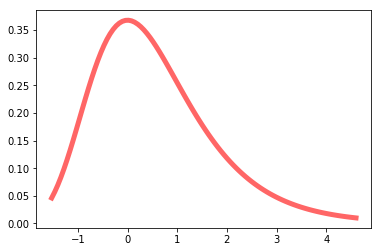

In [17]:
from scipy.stats import gumbel_r
import numpy as np
ax = plt.axes()
x = np.linspace(gumbel_r.ppf(0.01),
                gumbel_r.ppf(0.99), 100)
ax.plot(x, gumbel_r.pdf(x),
        'r-', lw=5, alpha=0.6, label='gumbel_r pdf')


In [18]:
iv = 0.1
df_gb = df_rain.groupby('station_id')#['rainfall_rate']#.pipe(lambda x: np.argwhere(np.diff(np.sign(x - iv))).flatten()[1])

from scipy import interpolate
import lmoments3 as lm
from lmoments3 import distr

#paras = distr.gam.lmom_fit(x)

def fit_gumbel(x):
    #x = x['rainfall_rate'].values
    N = x.shape[0]
    euler = 0.5772156649
    if N >= 10:
        paras = distr.gum.lmom_fit(x)
        #fitted_gum = distr.gum(**paras)
        #exval = fitted_gum.ppf(0.1)
        lmoments = distr.gum.lmom(nmom=2, **paras)
        #lmoments = lm.lmom(x, nmom=2)
        alpha = lmoments[1]/np.log(2)
        xi = lmoments[0] - euler*alpha 
        ok = get_gumbel_design_value(xi, alpha)
        return ok
    
def get_gumbel_design_value(xi, alpha):
    gamma = 0.1 + np.exp(-np.exp(xi/alpha))
    est = xi - alpha*np.log(-np.log(gamma))
    return est

dv = []

df_rain = df_rain.join(df_rain.groupby('station_id')['rainfall_rate'].apply(fit_gumbel), on='station_id', rsuffix='_new')

#for name, group in df_gb:
#    #if group.values.shape[0] >= 10:
#    # print the data of that regiment
#   #print('group', group.values)
#    #print(group['rainfall_rate'])
#    df_grouped.groupby(level=[0, 1, 2]).apply(fancy_func)
#    df_gb.['new'] = fit_gumbel(group['rainfall_rate'].values)
#
#print(dv[np.where(dv >= 0)])

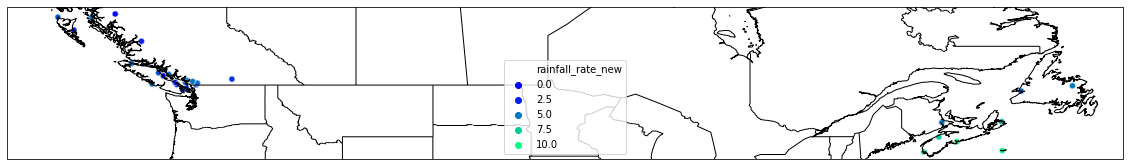

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df_rain['lon'], df_rain['lat'], hue=df_rain['rainfall_rate_new'], palette="winter", alpha=.3)
plt.savefig('./plots/canada_15_min_rain.pdf')
#plt.ylim(40, 80)
#plt.xlim(-126, -119)

In [443]:
#df_rain['15_min_rain_extreme']

In [365]:
#df_rain_rate['obs_count'].value_counts().idxmax()

In [366]:
df_dv = pd.DataFrame(dv, columns=['dv'])

In [367]:
df_dv

,dv
0,4.230989
1,6.475732
2,3.763945
3,5.438313
4,4.721381
5,4.270647
6,4.175265
7,7.563507
8,7.414885
9,6.583697


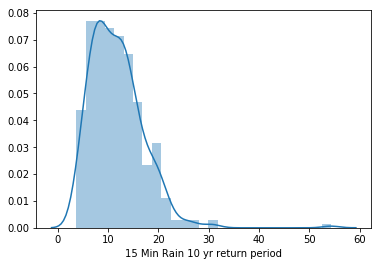

In [373]:
sns.distplot(df_dv[df_dv['dv'] < 60]['dv'])#.hist(bins = 100)
plt.xlabel('15 Min Rain 10 yr return period')
plt.savefig('./plots/15_min_rain.pdf')

In [437]:
a = np.arange(10)
b = np.linspace(0, 100, a.shape[0])
print('a', a)
print('b', b)
print('where', np.where(a<8, b, np.nan))

a [0 1 2 3 4 5 6 7 8 9]
b [  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]
where [ 0.         11.11111111 22.22222222 33.33333333 44.44444444 55.55555556
 66.66666667 77.77777778         nan         nan]
